In [ ]:
#cnn_colab/
#├── experiments/
#│   ├── exp1_baseline.ipynb
#│   ├── exp2_deep_cnn.ipynb
#│   ├── exp3_dropout.ipynb
#│   ├── exp4_augmentation.ipynb
#│
#├── models/
#│   ├── cnn_baseline.h5
#│   ├── cnn_optimized.h5
#│
#├── results/
#│   ├── accuracy_loss_plots.png
#│   ├── comparison_table.csv
#│
#└── README.md



In [2]:
import tensorflow as tf
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split
import numpy as np

# --- STEP 1: DATA COLLECTION ---
print("Fetching data from Keras library...")
# CIFAR-10 contains 60,000 32x32 color images in 10 classes
(x_train_full, y_train_full), (x_test, y_test) = datasets.cifar10.load_data()

# --- STEP 2: SPLITTING

print("Splitting data into Train, Validation, and Test sets...")
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full # for equal class split
)

# Statistics
print(f"\nData successfully loaded and split:")
print(f"Total Training images: {len(x_train)}")
print(f"Total Validation images: {len(x_val)}")
print(f"Total Test images: {len(x_test)}")
print(f"Image Shape: {x_train[0].shape}")

Fetching data from Keras library...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Splitting data into Train, Validation, and Test sets...

Data successfully loaded and split:
Total Training images: 40000
Total Validation images: 10000
Total Test images: 10000
Image Shape: (32, 32, 3)


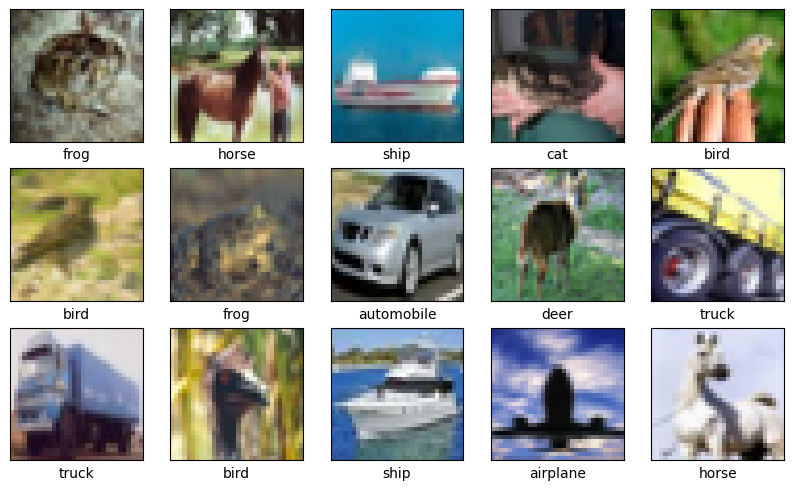

In [3]:
import matplotlib.pyplot as plt

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting 15 random images from the training set
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # Die labels are arrays, so we need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [4]:
# Normalization
print("Normalizing images...")
x_train = x_train.astype("float32") / 255.0
x_val   = x_val.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0


Normalizing images...


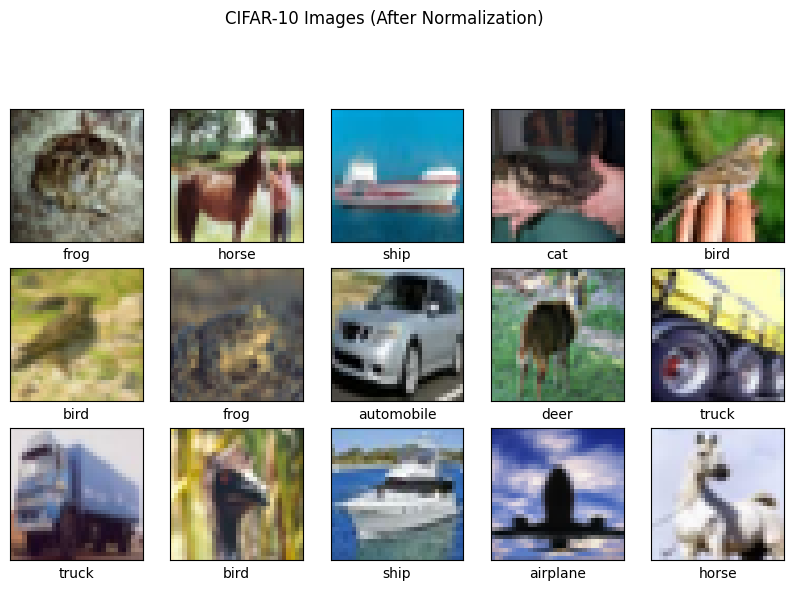

In [5]:
# Visualize AFTER Normalization
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.suptitle("CIFAR-10 Images (After Normalization)")
plt.show()


In [6]:
# Label Reshaping
y_train = y_train.reshape(-1)
y_val   = y_val.reshape(-1)
y_test  = y_test.reshape(-1)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Architecture Setup: Defining a Sequential CNN model
model_baseline = models.Sequential([
    # First Convolutional Block: Feature extraction
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block: Higher-level feature learning
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fully Connected Block: Flattening and Classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    # Output Layer: Softmax for multi-class probability (10 classes)
    layers.Dense(10, activation='softmax')
])

# 2. Model Compilation: Configuring Optimizer, Loss, and Metrics
model_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Custom Learning Rate
    loss='sparse_categorical_crossentropy',                 # Multi-class loss function
    metrics=['accuracy']                                    # Tracking accuracy during training
)

print("✅ Baseline Model successfully initialized and compiled!")
model_baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Baseline Model successfully initialized and compiled!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 3. Training the Baseline Model
print("Starting Training: Scenario 1 - Baseline...")
history_baseline = model_baseline.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    batch_size=64
)

# 4. Saving the model to the specific folder structure
model_save_path = 'cnn_colab/models/cnn_baseline.h5'
model_baseline.save(model_save_path)

print(f"✅ Model training complete and saved at: {model_save_path}")

Starting Training: Scenario 1 - Baseline...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3228 - loss: 1.8579 - val_accuracy: 0.4830 - val_loss: 1.4172
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5292 - loss: 1.3394 - val_accuracy: 0.5721 - val_loss: 1.2182
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5950 - loss: 1.1593 - val_accuracy: 0.6104 - val_loss: 1.1211
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6274 - loss: 1.0653 - val_accuracy: 0.6202 - val_loss: 1.1085
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6465 - loss: 1.0007 - val_accuracy: 0.6520 - val_loss: 1.0144
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6733 - loss: 0.9378 - val_accuracy: 0.6641 - val_loss: 0.9950
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6929 - loss: 0.8835 - val_accuracy: 0.6680 - val_loss: 0.9695
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accura

✅ Model training complete and saved at: cnn_colab/models/cnn_baseline.h5


In [10]:
import os

# This creates the main project folder and all sub-folders at once
project_path = 'cnn_colab'
sub_folders = ['experiments', 'models', 'results']

for folder in sub_folders:
    folder_path = os.path.join(project_path, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created: {folder_path}")
    else:
        print(f"Already exists: {folder_path}")

print("\n✅ Your folder structure is ready. You can now save your models and plots!")

Created: cnn_colab/experiments
Already exists: cnn_colab/models
Created: cnn_colab/results

✅ Your folder structure is ready. You can now save your models and plots!


In [11]:
# Saving the model you already trained into the 'models' folder
model_baseline.save('cnn_colab/models/cnn_baseline.h5')
print("✅ Baseline model saved successfully in cnn_colab/models/")

✅ Baseline model saved successfully in cnn_colab/models/


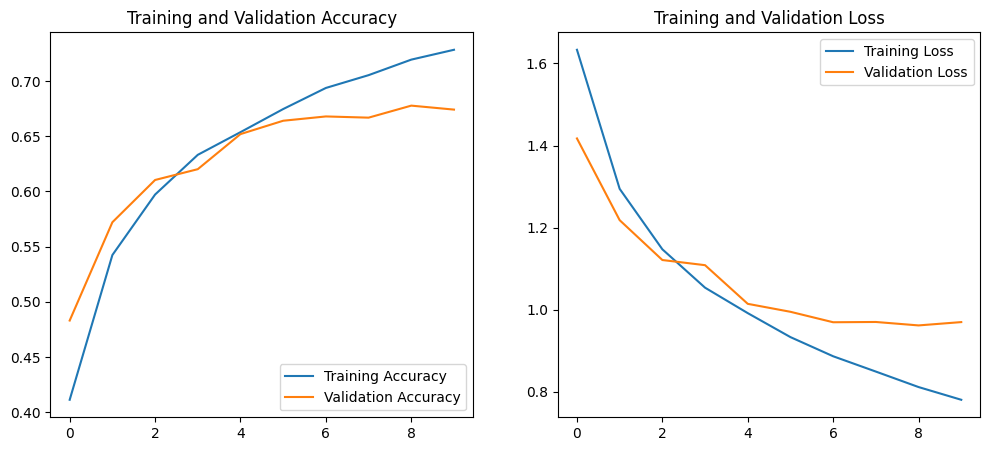

In [12]:
# learning curve
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')

    # Save the plot in the results folder
    plt.savefig('cnn_colab/results/baseline_learning_curves.png')
    plt.show()

plot_history(history_baseline)

In [13]:
# Classification Report
from sklearn.metrics import classification_report
import numpy as np

# 1. Get predictions from the model
print("Generating predictions for the test set...")
y_pred_probs = model_baseline.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 3. Generate the report
report = classification_report(y_test, y_pred, target_names=class_names)
print("\n--- Classification Report ---")
print(report)

# 4. Save the report to a text file in the results folder
report_path = 'cnn_colab/results/baseline_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(f"✅ Classification report saved at: {report_path}")

Generating predictions for the test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    airplane       0.66      0.74      0.70      1000
  automobile       0.79      0.85      0.82      1000
        bird       0.55      0.56      0.56      1000
         cat       0.43      0.62      0.51      1000
        deer       0.74      0.42      0.54      1000
         dog       0.59      0.56      0.57      1000
        frog       0.78      0.70      0.74      1000
       horse       0.75      0.71      0.73      1000
        ship       0.76      0.79      0.78      1000
       truck       0.80      0.72      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000

✅ Classification report saved at: cnn_colab/results/baseline_report.txt


In [16]:
# 1. Defining the Augmented Model (Scenario B)
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Define the Data Augmentation layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

# 2. Build the Optimized Model using those layers
model_optimized = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# 3. Compile the model
model_optimized.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Start Training immediately
print("Starting Training: Scenario B - Data Augmentation...")
history_optimized = model_optimized.fit(
    x_train, y_train,
    epochs=15,
    validation_data=(x_val, y_val),
    batch_size=64
)

# 5. Save the model to your folder
model_opt_path = 'cnn_colab/models/cnn_optimized.keras'
model_optimized.save(model_opt_path)

print(f"✅ Training complete and model saved at: {model_opt_path}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Training: Scenario B - Data Augmentation...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3136 - loss: 1.8781 - val_accuracy: 0.4889 - val_loss: 1.4213
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4803 - loss: 1.4493 - val_accuracy: 0.5319 - val_loss: 1.3582
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5244 - loss: 1.3226 - val_accuracy: 0.5642 - val_loss: 1.2265
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5484 - loss: 1.2677 - val_accuracy: 0.5694 - val_loss: 1.2519
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5717 - loss: 1.2087 - val_accuracy: 0.6182 - val_loss: 1.1173
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5889 - loss: 1.1589 - val_accuracy: 0.6039 - val_loss: 1.1474
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5993 - loss: 1.1356 - val_accuracy: 0.6271 - val_loss: 1.0768
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/s

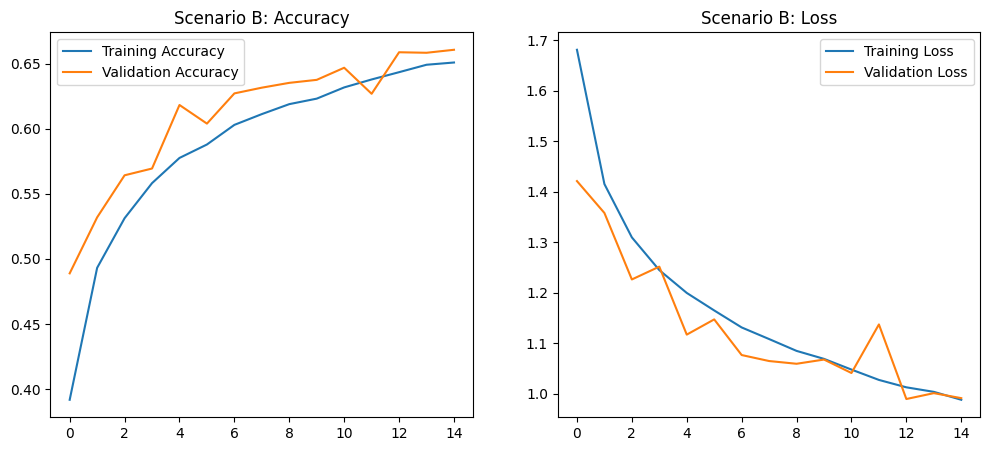

In [17]:
# Generate Scenario B Visualization
import matplotlib.pyplot as plt

def plot_optimized_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Scenario B: Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Scenario B: Loss')
    plt.legend()

    plt.savefig('cnn_colab/results/optimized_learning_curves.png')
    plt.show()

plot_optimized_history(history_optimized)

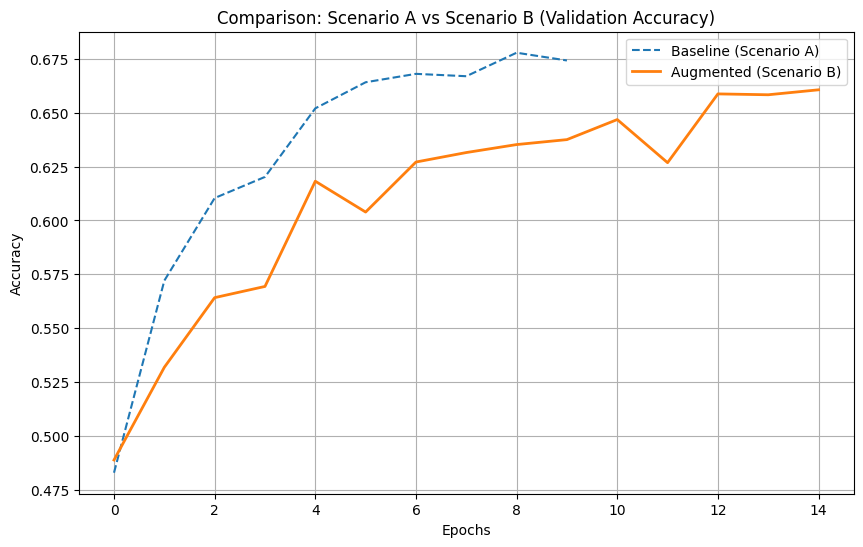

In [18]:
# Comparison Plot (The "Project Killer" Visual)
plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['val_accuracy'], label='Baseline (Scenario A)', linestyle='--')
plt.plot(history_optimized.history['val_accuracy'], label='Augmented (Scenario B)', linewidth=2)
plt.title('Comparison: Scenario A vs Scenario B (Validation Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('cnn_colab/results/A_vs_B_comparison.png')
plt.show()

In [19]:
# Save Optimized Classification Report
from sklearn.metrics import classification_report
import numpy as np

# Prediction
y_pred_opt = np.argmax(model_optimized.predict(x_test), axis=1)
report_opt = classification_report(y_test, y_pred_opt, target_names=class_names)

# Save to file
with open('cnn_colab/results/optimized_report.txt', 'w') as f:
    f.write(report_opt)

print("✅ Scenario B report saved in results folder!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Scenario B report saved in results folder!


In [20]:
# Build Scenario C Model (Dropout & Advanced Architecture)
# 1. Defining Scenario C Model with Dropout
model_final = models.Sequential([
    data_augmentation, # Keeping augmentation from Scenario B

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # 20% neurons dropped here

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), # 30% neurons dropped here

    # Fully Connected Block
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Increased units to 128
    layers.Dropout(0.5), # 50% neurons dropped at the final stage

    layers.Dense(10, activation='softmax')
])

# 2. Compiling with Adam Optimizer
model_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Scenario C Model (with Dropout) is ready for training!")


✅ Scenario C Model (with Dropout) is ready for training!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Training & Saving Scenario C
print("Starting Training: Scenario C - Dropout & Optimization...")
history_final = model_final.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    batch_size=64
)

# Save the final model in native Keras format
final_model_path = 'cnn_colab/models/cnn_final_dropout.keras'
model_final.save(final_model_path)

print(f"✅ Final Model saved at: {final_model_path}")

Starting Training: Scenario C - Dropout & Optimization...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2723 - loss: 1.9862 - val_accuracy: 0.4634 - val_loss: 1.4932
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4320 - loss: 1.5811 - val_accuracy: 0.5108 - val_loss: 1.3868
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4672 - loss: 1.4818 - val_accuracy: 0.5720 - val_loss: 1.2075
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4971 - loss: 1.4160 - val_accuracy: 0.5774 - val_loss: 1.1848
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5092 - loss: 1.3701 - val_accuracy: 0.5830 - val_loss: 1.1664
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5226 - loss: 1.3468 - val_accuracy: 0.6014 - val_loss: 1.1158
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5304 - loss: 1.3177 - val_accuracy: 0.6171 - val_loss: 1.0966
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms

In [22]:
# Scenario C ki Evaluation & Report
import numpy as np
from sklearn.metrics import classification_report

# 1. Prediction with Final Model
y_pred_final = np.argmax(model_final.predict(x_test), axis=1)
report_final = classification_report(y_test, y_pred_final, target_names=class_names)

# 2. Save Report
with open('cnn_colab/results/final_dropout_report.txt', 'w') as f:
    f.write(report_final)

print("✅ Final Dropout report saved!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Final Dropout report saved!


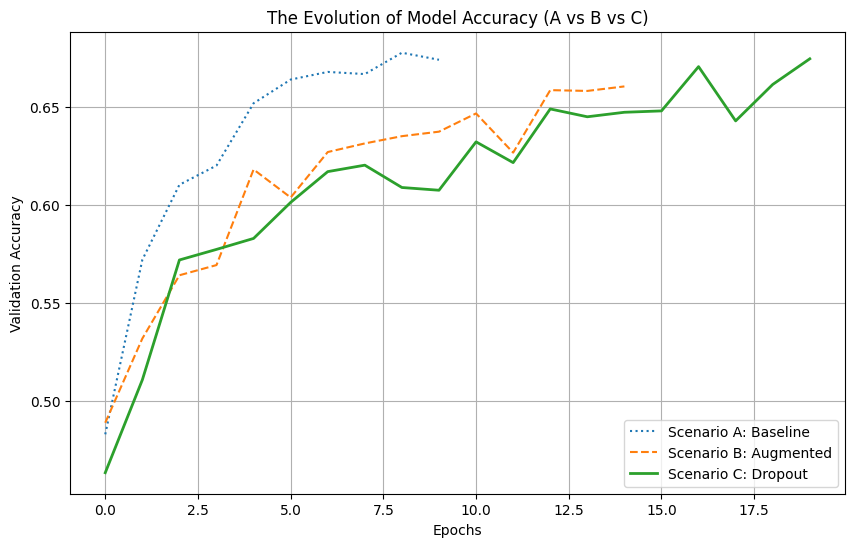

In [23]:
# Triple Comparison Plot (A vs B vs C)
plt.figure(figsize=(10, 6))

# Plotting all three scenarios
plt.plot(history_baseline.history['val_accuracy'], label='Scenario A: Baseline', linestyle=':')
plt.plot(history_optimized.history['val_accuracy'], label='Scenario B: Augmented', linestyle='--')
plt.plot(history_final.history['val_accuracy'], label='Scenario C: Dropout', linewidth=2)

plt.title('The Evolution of Model Accuracy (A vs B vs C)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Save the mega-comparison
plt.savefig('cnn_colab/results/final_mega_comparison.png')
plt.show()